## Análise de sentimentos sobre linhas aéreas (Parte 1/4)

Este notebook faz parte de um conjunto de notebooks com o objetivo de realizar a tarefa de análise de sentimentos em tweets sobre linhas aéreas americanas. 

Neste primeiro notebook, faremos uma análise exploratória dos tweets utilizados para treinamento do modelo. A base utilizada se encontra [aqui](https://www.kaggle.com/crowdflower/twitter-airline-sentiment). 

In [1]:
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from nltk.stem.snowball import SnowballStemmer

import numpy

%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.style.use('ggplot')

## Importação dos arquivos

Importaremos o arquivo contendo os tweets e mais duas lista de palavras consideradas como positivas ou negativas (entenda por pejorativas)

In [2]:
tweetsDF = pd.read_csv("Tweets.csv")

with open("lexicons/positive-words.txt") as file:
    positiveList = set(file.read().splitlines())
    
with open("lexicons/negative-words.txt") as file:
    negativeList = set(file.read().splitlines())

In [3]:
tweetsDF.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,...,tweet_coord,tweet_created,tweet_location,user_timezone,info1,info2,info3,info4,info5,info6
0,"5,70306133677761E+017",neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,...,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),NaN,NaN,NaN,NaN,NaN,NaN
1,"5,70301130888122E+017",positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),NaN,NaN,NaN,NaN,NaN,NaN
2,"5,70301083672814E+017",neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),NaN,NaN,NaN,NaN,NaN,NaN
3,"5,70301031407624E+017",negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),NaN,NaN,NaN,NaN,NaN,NaN
4,"5,70300817074463E+017",negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),NaN,NaN,NaN,NaN,NaN,NaN


In [196]:
# tweetsDF.drop(labels=['tweet_id',
#                       'name',
#                       'retweet_count',
#                       'tweet_coord',
#                       'tweet_created',
#                       'tweet_location', 
#                       'user_timezone',
#                      'info1', "info2", 'info3', 'info4', 'info5', 'info6'], axis=1, inplace=True)

## Distribuicao ao longo do tempo
Vamos analisar como estao distribuidos os tweets ao longo do tempo. Primeiro, precisamos transformar os dados que estão no formato de uma string para um objeto datetime. Perceba que as datas possuem um formato especifico: "yyyy-mm-dd hh:mm:ss -0800". Sendo assim, isso será informado na formatação dos timestamps. 

In [5]:
d = tweetsDF["tweet_created"].iloc[0]
d

'2015-02-24 11:35:52 -0800'

In [6]:
import datetime

In [8]:
# dateTimeObj = datetime.datetime.strptime(d, "%Y-%m-%d %H:%M:%S -0800")
tweetsDF["tweet_created"] = pd.to_datetime(tweetsDF["tweet_created"],format="%Y-%m-%d %H:%M:%S -0800",errors='coerce')
tweetsDF['day-month'] = tweetsDF["tweet_created"].dt.strftime("%d-%m")

Após transformar os dados, iremos agrupá-los por dia do mês. Veremos que os tweets foram postados de 16 a 23 de Fevereiro de 2018

In [9]:
dfDate = tweetsDF.groupby(by='day-month')
dateCounter = dfDate.count()
dateCounter
dateCounter.to_excel('training_frequency.xls')

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,...,tweet_coord,tweet_created,tweet_location,user_timezone,info1,info2,info3,info4,info5,info6
day-month,,,,,,,,,,,,,,,,,,,,,
16-02,4,4,4,3,3,4,0,4,0,4,...,0,4,3,3,0,0,0,0,0,0
17-02,1354,1354,1354,805,950,1354,5,1354,4,1354,...,100,1354,950,921,0,0,0,0,0,0
18-02,1277,1277,1277,692,819,1277,1,1277,1,1277,...,88,1277,899,927,0,0,0,0,0,0
19-02,1319,1319,1319,719,844,1319,5,1319,3,1319,...,102,1319,864,884,0,0,0,0,0,0
20-02,1443,1443,1443,798,917,1443,5,1443,4,1443,...,99,1443,1057,986,0,0,0,0,0,0
21-02,1510,1510,1510,1018,1148,1510,6,1510,5,1510,...,113,1510,1037,1033,0,0,0,0,0,0
22-02,2956,2956,2956,2175,2396,2956,7,2956,6,2956,...,191,2956,1923,1896,0,0,0,0,0,0
23-02,2924,2924,2924,1846,2141,2924,6,2924,5,2924,...,204,2924,1945,1892,0,0,0,0,0,0
24-02,1290,1290,1290,751,889,1290,4,1290,3,1290,...,74,1290,819,888,1,0,0,0,0,0


In [10]:
labels = tweetsDF['day-month'].unique()
labels.sort()
labels

array(['16-02', '17-02', '18-02', '19-02', '20-02', '21-02', '22-02',
       '23-02', '24-02', 'NaT'], dtype=object)

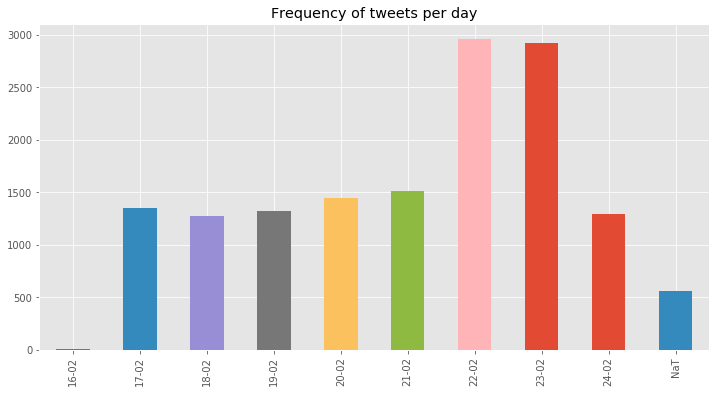

In [11]:
_ = dateCounter.plot(x=labels,
                 y="tweet_id", 
                 figsize=(12,6),
                title="Frequency of tweets per day",
                kind='bar',
                legend=False)

Nos dias 22 e 23 de Fevereiro a atividade no Twitter quase dobrou. Olhando no Google Notícias encontramos algumas manchetes que podem ter ocasionado esse aumento

* [Machete 1](link)
* [Machete 2](link)
* [Machete 3](link)

---
Agora vamos olhar os dados ausentes. Vamos calcular a porcentage de dados não ausentes verificar como está a distribuição dos dados

In [12]:
print("Porcentagem de dados nao nulos")
(len(tweetsDF)-tweetsDF.count())/len(tweetsDF)*100

Porcentagem de dados nao nulos


tweet_id                         0.000000
airline_sentiment                0.000000
airline_sentiment_confidence     0.000000
negativereason                  37.308743
negativereason_confidence       28.128415
airline                          0.000000
airline_sentiment_gold          99.726776
name                             0.000000
negativereason_gold             99.781421
retweet_count                    0.000000
text                             0.000000
tweet_coord                     89.528689
tweet_created                    3.845628
tweet_location                  31.577869
user_timezone                   32.752732
info1                           97.281421
info2                           99.733607
info3                           99.945355
info4                           99.972678
info5                           99.979508
info6                           99.993169
day-month                        0.000000
dtype: float64

Como as colunas 'airline_sentiment_gold' e 'negativereason_gold' estão praticamente inteiras com valores nulos, iremos deleta-las

In [13]:
tweetsDF.drop(labels=['airline_sentiment_gold',
                      'negativereason_gold'], axis=1,inplace=True)

In [14]:
tweetsDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 20 columns):
tweet_id                        14640 non-null object
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
name                            14640 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1533 non-null object
tweet_created                   14077 non-null datetime64[ns]
tweet_location                  10017 non-null object
user_timezone                   9845 non-null object
info1                           398 non-null object
info2                           39 non-null object
info3                           8 non-null object
info4                         

Ainda assim existem algumas colunas com muito lixo, como a info1, info2 e assim por diante. Mais a frente, essas colunas serão excluídas do dataframe

---

Vamos preencher a coluna "negativereason_confidence" com dados da média

In [15]:
from sklearn.preprocessing import Imputer
imputer = Imputer()

# transformed = imputer.fit_transform(tweetsDF["negativereason_confidence"])
negativeMean = tweetsDF["negativereason_confidence"].mean()
tweetsDF["negativereason_confidence"].fillna(negativeMean, inplace=True)
tweetsDF["negativereason"].fillna("Can't Tell", inplace=True)

/home/victor/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Como é possível observar, agora as colunas preenchidas possuem o total de 14640 campos não nulos, o que corresponde ao total de linhas no dataframe

In [16]:
tweetsDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 20 columns):
tweet_id                        14640 non-null object
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  14640 non-null object
negativereason_confidence       14640 non-null float64
airline                         14640 non-null object
name                            14640 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1533 non-null object
tweet_created                   14077 non-null datetime64[ns]
tweet_location                  10017 non-null object
user_timezone                   9845 non-null object
info1                           398 non-null object
info2                           39 non-null object
info3                           8 non-null object
info4                        

Vamos observar a distribuição das classes positivas, negativas e neutras dos tweets

In [18]:
## Distribuição de sentimentos
sentimentCounter = tweetsDF['airline_sentiment'].value_counts()
sentimentCounter

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

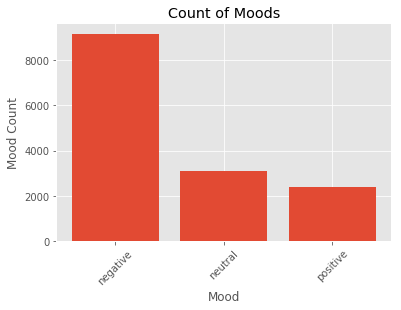

In [19]:
Index = [1,2,3]
_ = plt.bar(Index,sentimentCounter)
_ = plt.xticks(Index,['negative','neutral','positive'],rotation=45)
_ = plt.ylabel('Mood Count')
_ = plt.xlabel('Mood')
_ = plt.title('Count of Moods')

## Distribuição de tweets por companhia

O dataset contém a informação sobre qual companhia aérea o tweet está se referindo. Logo, vamos olhar a distribuição dos tweets separados por cia.

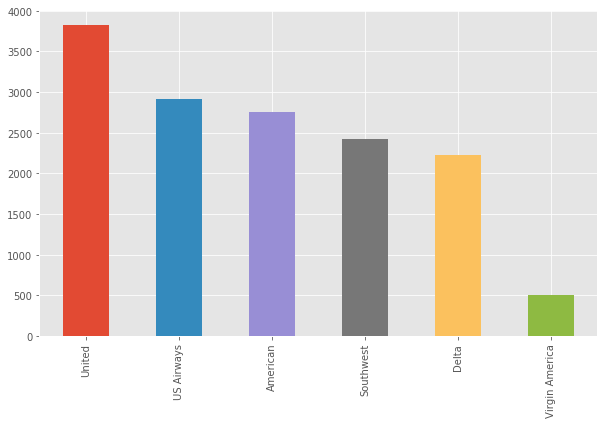

In [23]:
_ = tweetsDF['airline'].value_counts().plot(kind='bar', figsize=(10,6))

E como será que as classes dos tweets estão distibuídos para cada companhia? Vamos olhar para o gráfico que mostrará isso

In [24]:
def plot_sub_sentiment(airline, tweet_df):
    df = tweet_df[tweet_df['airline']==airline]
    count = df['airline_sentiment'].value_counts()
    index = [1,2,3]
    plt.bar(index,count)
    plt.xticks(index,['negative','neutral','positive'])
    plt.ylabel('Frequencia')
    plt.xlabel('Sentimento')
    plt.title('Dist de sentimentos ' + airline)
#     plt.ylim(0, len(tweet_df))
    plt.ylim(0, 3000)

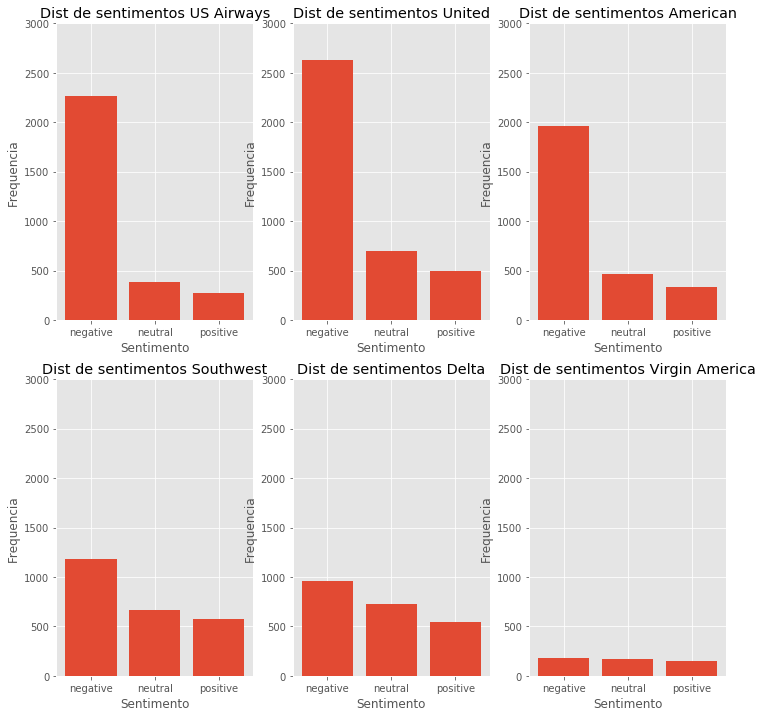

In [25]:
plt.figure(1,figsize=(12, 12))
plt.subplot(231)
plot_sub_sentiment('US Airways', tweetsDF)

plt.subplot(232)
plot_sub_sentiment('United', tweetsDF)

plt.subplot(233)
plot_sub_sentiment('American', tweetsDF)

plt.subplot(234)
plot_sub_sentiment('Southwest', tweetsDF)

plt.subplot(235)
plot_sub_sentiment('Delta', tweetsDF)

plt.subplot(236)
plot_sub_sentiment('Virgin America', tweetsDF)

De acordo com o gráfico, a United Airlines é que mais tem tweets a seu respeito. Isso parece ser razoável já que a United Airlines é maior copmanhia no mundo em termos de destinos possíveis. 

---
## Motivos de reclamação
O dataset também traz qual o motivo da reclamação. Vamos analisar a distribuição desses motivos

In [26]:
nrCounter = dict(tweetsDF['negativereason'].value_counts(sort=False))


In [32]:
def NR_Count(Airline, tweet_df):
    if Airline == 'All':
        df = tweet_df
    else:
        df = tweet_df[tweet_df['airline'] == Airline]
    
    count = dict(df['negativereason'].value_counts())
    Unique_reason = list(tweet_df['negativereason'].unique())
    Unique_reason = [x for x in Unique_reason if str(x) != 'nan']
    Reason_frame = pd.DataFrame({'Reasons':Unique_reason})
    Reason_frame['count'] = Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame

def plot_reason(Airline, tweet, ylim):
    df = NR_Count(Airline, tweet)
    count = df['count']
    Index = range(1,(len(df)+1))
    plt.bar(Index,count,)
#     plt.xticks(Index,df['Reasons'],rotation=45,)
    plt.xticks(Index,legends.values(),rotation=45,)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.ylim((0,ylim))
    plt.title('Count of Reasons for '+Airline)

In [33]:
Unique_reason = list(tweetsDF['negativereason'].unique())
Unique_reason = [x for x in Unique_reason if str(x) != 'nan']

legends = dict()
for line in Unique_reason:
    words = line.split()
    letters = [word[0].upper() for word in words]
    legends[line] = "".join(letters)
legends

{'Bad Flight': 'BF',
 "Can't Tell": 'CT',
 'Cancelled Flight': 'CF',
 'Customer Service Issue': 'CSI',
 'Damaged Luggage': 'DL',
 'Flight Attendant Complaints': 'FAC',
 'Flight Booking Problems': 'FBP',
 'Late Flight': 'LF',
 'Lost Luggage': 'LL',
 'longlines': 'L'}

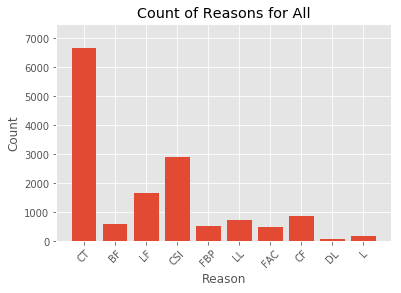

In [34]:
plot_reason('All', tweetsDF, ylim=7500)


Reclamacoes sobre o servico ao cliente sao as mais frequentes, seguidas de atraso de voo. É interessante notar que mais de 1000 reclamacoes estao em categorias diversas.

## Motivos de reclamacoes por companhia
Vamos analisar as reclamacoes por cada companhia

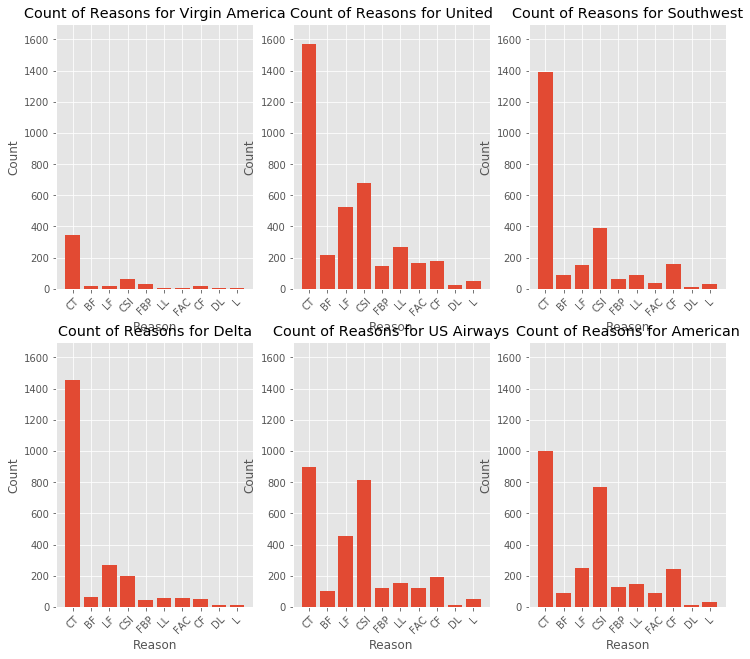

In [35]:
companies = list(tweetsDF["airline"].unique())
subPlot = 231
_ = plt.figure(1,figsize=(12, 12))

for c in companies:
    _ = plt.subplots_adjust(top=0.8)
    _ = plt.subplot(subPlot)
    plot_reason(c, tweetsDF, 1700)
    
    subPlot += 1

Em todas as companhias, a maior reclamacao é a do serviço ao cliente. Agora vamos plotar um wordcloud para ver quais as palavras mais frequentemente usadas. 

In [36]:
from wordcloud import WordCloud, STOPWORDS

In [37]:
df = tweetsDF[tweetsDF["airline_sentiment"]=='negative']
words = ' '.join(df["text"])
cleanedWord = " ".join([w for w in words.split()
                            if "http" not in w
                            and not w.startswith("@")
                            and w != "RT"
                       ])

In [38]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleanedWord)

(-0.5, 2999.5, 2499.5, -0.5)

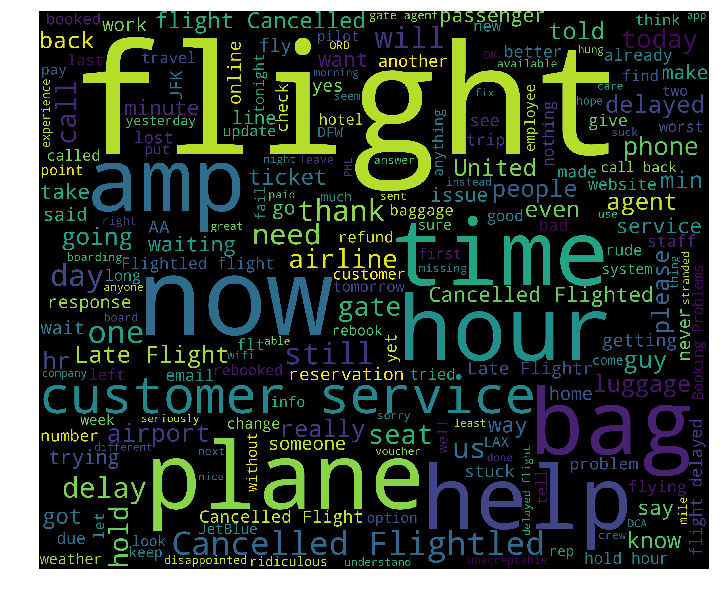

In [39]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Como as reclamacoes mais frequentes estao relacionadas ao servico ao consumidor e as palavras mais frequentes são "plane", "bag", "flight", podemos propor que a qualidade das aeronaves nao satisfaz os consumidores. Podem haver problemas com as bagagens de mao (espaço insuficiente, ou incovenientes). Além disso, a oferta de voos tambem pode ser um motivo de reclamacao

## Extração de características
Características basedas [neste](https://www.microsoft.com/en-us/research/wp-content/uploads/2015/03/main.pdf) trabalho serão utilizadas. Vale ressaltar que o autor extraiu 34 características. Nem todas elas serão extraídas aqui.

In [40]:
# feature 3
def countPositiveCapitalized(tokens):
    """
    Calculates the number of positive words that are capitalized
    
    @params:
        tokens: The non stopwords list
    """
    counter = 0
    tokensSplit = tokens.split()
    for t in tokensSplit:
        if t[0].isupper() == True and t in positiveList:
            counter += 1
    return counter

# feature 4
def countNegativeCapitalized(tokens):
    """
    Calculates the number of negative words that are capitalized
    
    @params:
        tokens: The non stopwords list
    """
    counter = 0
    tokensSplit = tokens.split()
    for t in tokensSplit:
        if t[0].isupper() == True and t in negativeList:
            counter += 1
    return counter

# feature 5
def hasCapitalized(tokens):
    """
    Check if the tweet has capitalized words
    
    @params:
        tokens: The non stopwords list
    """
    counter = 0
    tokensSplit = tokens.split()
    for t in tokensSplit:
        if t[0].isupper() == True:
            return 1
    return 0

# feature 6
def countHashtags(tokens):
    """
    Count the number of words that starts with # (hashtags)
    
    @params:
        tokens: The non stopwords list
    """
    counter = 0
    for t in tokens:
        if t.startswith("#"):
            counter += 1
    return counter

# feature 7
def countPositive(tokens):
    """
    Calculates the number of words that are in the positive words list
    
    @params:
        tokens: The non stopwords list
    """
    counter = 0
    tokensSplit = tokens.split()
    for t in tokensSplit:
        if t.lower() in positiveList:
            counter += 1
    return counter

# feature 8
def countNegative(tokens):
    """
    Calculates the number of words that are in the negative words list
    
    @params:
        tokens: The non stopwords list
    """
    counter = 0
    tokensSplit = tokens.split()
    for t in tokensSplit:
        if t.lower() in negativeList:
            counter += 1
    return counter

# feature 9
def countNeutral(tokens):
    """
    Calculates the number of words that are in the neutral words list
    
    @params:
        tokens: The non stopwords list
    """
    counter = 0
    tokensSplit = tokens.split()
    for t in tokensSplit:
        if t.lower() not in negativeList and t.lower() not in positiveList:
            counter += 1
    return counter

# feature 10
def countCapitalizedWords(tokens):
    """
    Calculates the number of words that are capitalized
    
    @params:
        tokens: The non stopwords list
    """
    counter = 0
    tokensSplit = tokens.split()
    for t in tokensSplit:
        if t.isupper() and len(t) > 1:
            counter += 1
    return counter

# feature 11
def countSpecialCharacters(tokens):
    """
    Calculates the number of occurrencies of all special character
    
    @params:
        tokens: The non stopwords list
    """
    counter = 0
    tokensSplit = tokens.split()
    for t in tokensSplit:
        if not re.match("^[a-zA-Z0-9_]*$", t):
            counter += 1
    return counter

def countSpecificSpecialCharacter(specialCharacter, tokens):
    """
    Calculates the number of occurrencies of a specific special character
    
    @params:
        tokens: The non stopwords list
    """
    counter = 0
    tokensSplit = tokens.split()
    for t in tokensSplit:
        if t == specialCharacter:
            counter += 1
    return counter

In [41]:
def fixSpelling(tokens):
    import hunspell
    spellchecker = hunspell.HunSpell('/usr/share/hunspell/en_US.dic',
                                 '/usr/share/hunspell/en_US.aff')
                           
    words = tokens.split()              
    newWords = ""#list()
    for w in words:
        if not spellchecker.spell(w):
#             newWords.append(spellchecker.suggest(w)[0])
            try:
                newWords += " " + spellchecker.suggest(w)[0]
            except(IndexError):
                newWords += " " + ""
        else:
#             newWords.append(w)
            newWords += " " + w
    return newWords
        
def stemming(tokens):
    '''
    Apply stemming to each token
    '''
    
    stemmer = SnowballStemmer("english")  
    stemmed = [stemmer.stem(w) for w in tokens.split()]
    return stemmed
   

## Preprocessamento

Agora iremos preparar os tweets para servirem de input aos classificadores

In [44]:
import re
import nltk
from nltk.corpus import stopwords

In [45]:
tweetsDF.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,info1,info2,info3,info4,info5,info6,day-month
0,"5,70306133677761E+017",neutral,1.0000,Can't Tell,13.160358,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52,NaN,Eastern Time (US & Canada),NaN,NaN,NaN,NaN,NaN,NaN,24-02
1,"5,70301130888122E+017",positive,0.3486,Can't Tell,0.000000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59,NaN,Pacific Time (US & Canada),NaN,NaN,NaN,NaN,NaN,NaN,24-02
2,"5,70301083672814E+017",neutral,0.6837,Can't Tell,13.160358,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48,Lets Play,Central Time (US & Canada),NaN,NaN,NaN,NaN,NaN,NaN,24-02
3,"5,70301031407624E+017",negative,1.0000,Bad Flight,0.703300,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36,NaN,Pacific Time (US & Canada),NaN,NaN,NaN,NaN,NaN,NaN,24-02
4,"5,70300817074463E+017",negative,1.0000,Can't Tell,1.000000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45,NaN,Pacific Time (US & Canada),NaN,NaN,NaN,NaN,NaN,NaN,24-02


In [46]:
def tweet2words(raw_tweet):
    """
    Split the tweet string into words list and remove stopwords
        
    @params:
        raw_tweet: the tweet string collectd
    """
    callout_regex = "@[A-Za-z0-9_]+"
    #Remove mencoes a perfis
    letters_only = re.sub(callout_regex, " ", raw_tweet)
    letters_only = re.sub("[^a-zA-Z]", " ", letters_only)
    
    words = letters_only.lower().split()                             
    words = letters_only.split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words )) 


def clean_tweet_length(raw_tweet):
    """
    Calculates the number of non stopwords
    
    @params:
        raw_tweet: the tweet string collectd
    """
    letters_only = re.sub("[^a-zA-Z]", " ",raw_tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return(len(meaningful_words)) 

In [47]:
tweetsDF['sentiment'] = tweetsDF['airline_sentiment'].apply(lambda x: 0 if x=="negative" else 1)

tweetsDF['tweet2words'] = tweetsDF['text'].apply(tweet2words)

tweetsDF["num_capitalized"] = tweetsDF["tweet2words"].apply(countCapitalizedWords)

tweetsDF['tweet_length'] = tweetsDF['text'].apply(clean_tweet_length)

tweetsDF["num_negative_words"] = tweetsDF["tweet2words"].apply(countNegative)

In [48]:
# Number of occurrencies
tweetsDF["num_positive_words"] = tweetsDF['text'].apply(countPositive)
tweetsDF["num_negative_words"] = tweetsDF['text'].apply(countNegative)
tweetsDF["num_neutral_words"] = tweetsDF['text'].apply(countNeutral)

# Capitalized words
tweetsDF["has_capitalized"] = tweetsDF['text'].apply(hasCapitalized)
tweetsDF["num_capitalised_positive_words"] = tweetsDF['text'].apply(countPositiveCapitalized)
tweetsDF["num_capitalised_negative_words"] = tweetsDF['text'].apply(countNegativeCapitalized)


tweetsDF["num_hashtags"] = tweetsDF['text'].apply(countHashtags)
tweetsDF["num_special_character"] = tweetsDF['text'].apply(countSpecialCharacters)

In [75]:
tweetsDF['correctedText'] =  tweetsDF['tweet2words'].apply(fixSpelling)


In [76]:
tweetsDF.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,text,sentiment,tweet2words,num_capitalized,tweet_length,num_negative_words,num_positive_words,num_neutral_words,has_capitalized,num_capitalised_positive_words,num_capitalised_negative_words,num_hashtags,num_special_character,correctedText
0,neutral,1.0000,Can't Tell,13.160358,Virgin America,@VirginAmerica What @dhepburn said.,1,What said,0,3,0,0,4,1,0,0,0,3,What said
1,positive,0.3486,Can't Tell,0.000000,Virgin America,@VirginAmerica plus you've added commercials t...,1,plus added commercials experience tacky,0,6,0,0,9,0,0,0,0,4,plus added commercials experience tacky
2,neutral,0.6837,Can't Tell,13.160358,Virgin America,@VirginAmerica I didn't today... Must mean I n...,1,I today Must mean I need take another trip,0,8,0,0,12,1,0,0,0,4,I today Must mean I need take another trip
3,negative,1.0000,Bad Flight,0.703300,Virgin America,@VirginAmerica it's really aggressive to blast...,0,really aggressive blast obnoxious entertainmen...,0,11,2,0,15,0,0,0,0,5,really aggressive blast obnoxious entertainme...
4,negative,1.0000,Can't Tell,1.000000,Virgin America,@VirginAmerica and it's a really big bad thing...,0,really big bad thing,0,5,1,0,9,0,0,0,0,2,really big bad thing


Agora vamos salvar o arquivo que servirá de input para o treino dos algoritmos

In [77]:
tweetsDF.to_csv('preprocessed2.csv')

## Tweets coletados
Foram coletados tweets diretamente do Twitter contendo menções aos perfis das companhias

In [49]:
from os import listdir
from os.path import isfile, join

tweetsPath = '02_prediction_tweets/'
onlyfiles = [f for f in listdir(tweetsPath) if isfile(join(tweetsPath, f))]

In [50]:
dfList = list()
for file in onlyfiles:
    tweetsDF = pd.read_csv(tweetsPath + file, error_bad_lines= False)
    
    dfList.append(tweetsDF)

b'Skipping line 1044: expected 14 fields, saw 15\nSkipping line 2542: expected 14 fields, saw 15\nSkipping line 2687: expected 14 fields, saw 16\nSkipping line 3856: expected 14 fields, saw 15\nSkipping line 5267: expected 14 fields, saw 16\nSkipping line 5268: expected 14 fields, saw 18\nSkipping line 6082: expected 14 fields, saw 15\nSkipping line 11608: expected 14 fields, saw 15\n'
b'Skipping line 796: expected 14 fields, saw 15\nSkipping line 2374: expected 14 fields, saw 15\n'


In [51]:
finalDF = pd.concat(dfList, axis=0)
dateTimeObj = datetime.datetime.strptime(d, "%Y-%m-%d %H:%M:%S -0800")
finalDF["year-month-day"] = pd.to_datetime(finalDF['date'],
                                           format="%Y-%m-%d %H:%M", 
                                           errors='coerce')
finalDF['month-year'] = finalDF["year-month-day"].dt.strftime("%m-%Y")
finalDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33684 entries, 0 to 5369
Data columns (total 19 columns):
Unnamed: 14            0 non-null float64
Unnamed: 15            1 non-null object
Unnamed: 16            1 non-null object
col1                   5866 non-null object
col2                   107 non-null object
col3                   19 non-null object
date                   33682 non-null object
favorites              33684 non-null object
geological_location    566 non-null object
hashtags               14719 non-null object
mentions               23510 non-null object
permalink              33594 non-null object
retweets               33683 non-null object
text                   33684 non-null object
tweet_id               30464 non-null object
user_handle            33681 non-null object
username               33683 non-null object
year-month-day         33419 non-null datetime64[ns]
month-year             33684 non-null object
dtypes: datetime64[ns](1), float64(1), object(17

In [52]:
finalDF.head(2)

,Unnamed: 14,Unnamed: 15,Unnamed: 16,col1,col2,col3,date,favorites,geological_location,hashtags,mentions,permalink,retweets,text,tweet_id,user_handle,username,year-month-day,month-year
0,NaN,NaN,NaN,NaN,NaN,NaN,2018-08-06 19:48,17,NaN,NaN,@AmericanAir,https://twitter.com/SecretFlying/status/102660...,7,"Chicago to Houston, Texas (& vice versa) for o...","1,02660088000989E+018",SecretFlying,Secret Flying,2018-08-06 19:48:00,08-2018
1,NaN,NaN,NaN,NaN,NaN,NaN,2018-08-06 19:29,13,NaN,#CLT #HVN,@AmericanAir @FlyTweed,https://twitter.com/NewHavenED/status/10265962...,8,We are very excited to see new commercial air ...,"1,0265962359297E+018",NewHavenED,NH Economic Dev,2018-08-06 19:29:00,08-2018


In [53]:
monthTweets = finalDF.groupby(by="month-year")
dateCounter = monthTweets.count()
dateCounter.to_excel("tweets_time.xls")

Vamos analisar a distribuição dos tweets ao long do tempo

array(['01-2018', '02-2018', '03-2018', '04-2018', '05-2018', '06-2017',
       '06-2018', '07-2017', '07-2018', '08-2017', '08-2018', '09-2017',
       '10-2017', '11-2017', '12-2017', 'NaT'], dtype=object)

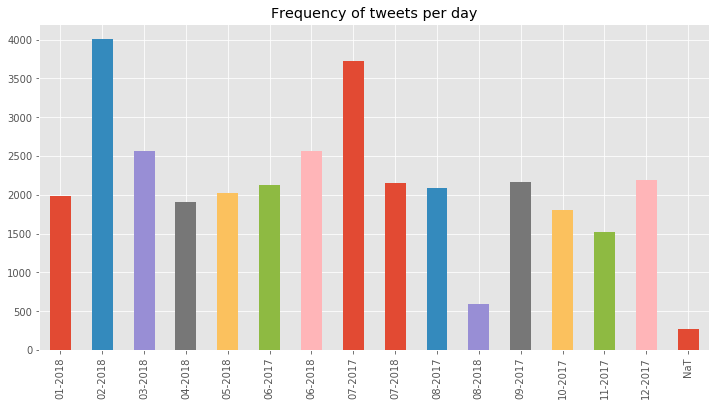

In [54]:
labels = finalDF['month-year'].unique()
labels.sort()
labels
_ = dateCounter.plot(x=labels,
                 y="text", 
                 figsize=(12,6),
                title="Frequency of tweets per day",
                kind='bar',
                legend=False)